# Generating Heatmaps
Code to set up heatmaps to gather insights from CNN training.

## Import Libraries
Import all necessary libraries for handling data and generating heatmaps.

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from PIL import Image 
import PIL 

## Import Models
In this case, we only need the pre-trained neural network.

In [3]:
from models.transferlearning import load_pretrained_model

## Import Dataset Class and Transforms
Used to help load in the images for heatmap generation

In [4]:
from utilities.dataset import ImageDataset
from utilities.transforms import data_transforms

## Function to Generate Heatmap
Uses the same workflow as testing the network, but instead of inferencing on each image, we save a heatmap, instead.

In [5]:
def generate_heatmap(transform, weights_path, batch_size, network, first, second):
    # Loading in initial test data
    print("\nLoading in data...")
    test_data = ImageDataset("test", transform, 0.6, first, second)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                            shuffle=True)
    print("Done loading in data.")

    # Test Loading
    dataiter = iter(testloader)
    images, labels, img_names = next(dataiter)

    # Loading in a new example of the neural net, and loading in the weights
    net = network
    if (torch.cuda.is_available()):
        net.to('cuda')
    net.load_state_dict(torch.load(weights_path))
    
    # Iterate through all of the images and their names and generate heatmaps
    print("Generate Heatmaps...")
    cam_extractor = SmoothGradCAMpp(net)
    for data in testloader:
        images, labels, img_names = data
        images_cuda, labels_cuda = images.cuda(), labels.cuda()
        for image_cuda, img_name in zip(images_cuda, img_names):
                # Generating the activation map
                out = net(image_cuda.unsqueeze(0))
                activation_map = cam_extractor(out.cpu().squeeze(0).argmax().item(), out.cpu())
                
                # Turning the image into a tensor
                current_image = Image.open(img_name)
                make_tensor = transforms.ToTensor()
                current_image = make_tensor(current_image)
                
                # Cropping the image
                crop_tensor = transforms.CenterCrop(224)
                current_image = crop_tensor(current_image)
                
                # Overlaying heatmap on top of the image
                result = overlay_mask(to_pil_image(current_image), to_pil_image(activation_map[0].cpu().squeeze(0), mode='F'), alpha=0.5)
                plt.imshow(result)
                plt.axis('off'); 
                plt.tight_layout()
                
                # Saving image
                name = "heatmaps/test/" + "heatmap_of_"+img_name.split('/')[-1]
                plt.savefig(name)

## Main Function
Runs all of the necessary functions!

In [6]:
def main(weights, first, second):
    # Define model and weights
    model = load_pretrained_model()
      
    # Generate the necessary heatmaps
    generate_heatmap(data_transforms['TransferLearning'], weights, 200, model, first, second)

## Run all code!
Runs all code to generate heatmaps!


Loading in data...
Done loading in data.


Generate Heatmaps...


KeyboardInterrupt: 

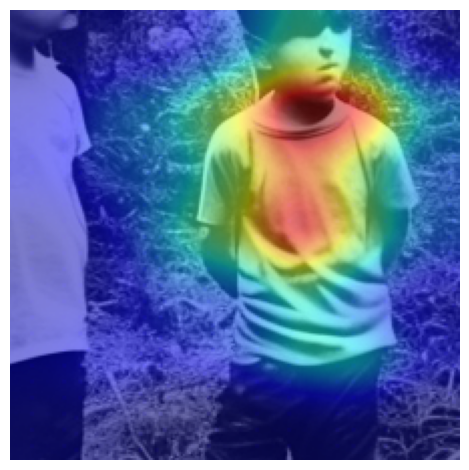

In [8]:
if __name__ == '__main__':
    main(weights='weights/TransferLearning-0.6-dallevsd.pth', first='dalle', second='stable-diffusion')